# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [63]:
import pandas as pd
import numpy as np

In [64]:
data = pd.read_csv('train.csv')

In [65]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [66]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [67]:
data.isnull().any() #пропуски есть в столбцах keyword и location

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [68]:
train = train.fillna('')
test = test.fillna('')
train.isnull().any()

id          False
keyword     False
location    False
text        False
target      False
dtype: bool

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [69]:
train['target'].value_counts() / train['target'].count() #распределение классов примерно равное. Проблема дисбаланса классов отсутствует

0    0.567461
1    0.432539
Name: target, dtype: float64

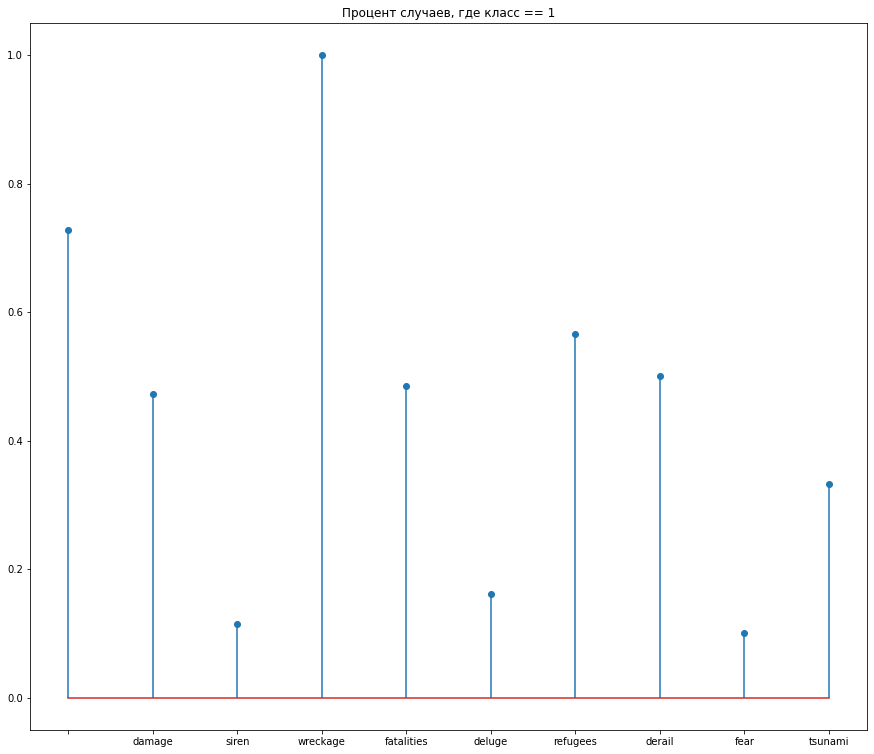

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

d = dict()
a = train['keyword'].value_counts()[0:10]
a = dict(a)
for i in a:
    counterFunc = train.apply(lambda x: True if (x['keyword'] == i and x['target'] == 1) else False, axis = 1) 
    counterFunc1 = train.apply(lambda x: True if x['keyword'] == i else False, axis = 1)
    d[i] = len(counterFunc[counterFunc == True].index) / len(counterFunc1[counterFunc1 == True].index)

fig, ax = plt.subplots(1,1,figsize = (15,13))
ax.stem(d.keys(), d.values())
ax.set_title('Процент случаев, где класс == 1')
plt.show()


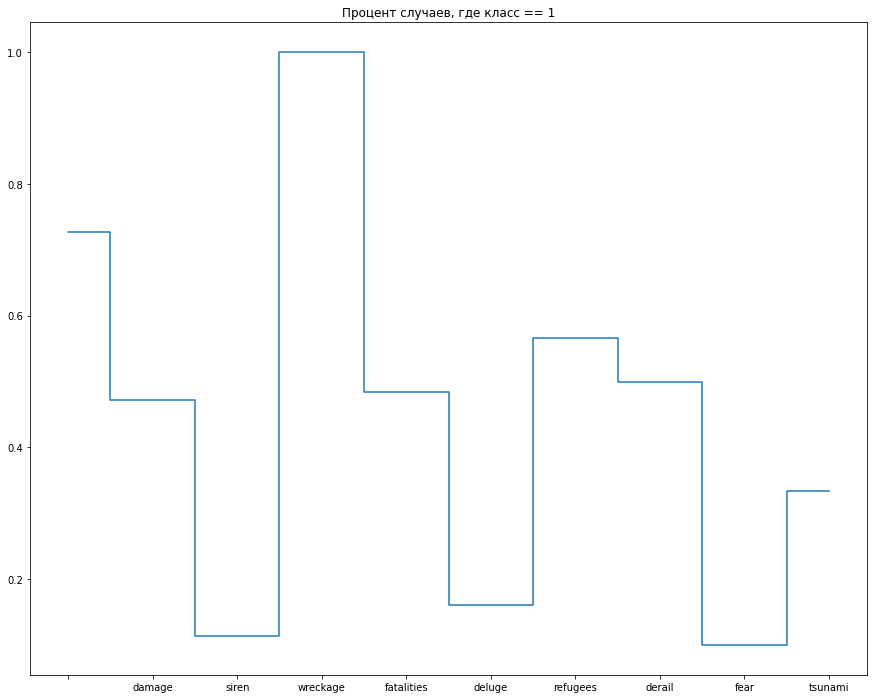

In [71]:
#альтернативный вариант
plt.figure(figsize=(15, 12))
plt.step(d.keys(), d.values(), where = 'mid')
plt.title('Процент случаев, где класс == 1')
plt.show()

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [72]:
dummy = train['keyword'] + ' ' + train['location'] + ' ' + train["text"]
train['text'] = dummy
train = train.set_index(train['id'])
train = train.drop(columns = ['keyword', 'location','id'])

dummy1 = test['keyword'] + ' ' + test['location'] + ' ' + test["text"]
test['text'] = dummy1
test = test.set_index(test['id'])
test = test.drop(columns = ['keyword', 'location','id'])
test

,text,target
id,,
3796,destruction So you have a new weapon that can...,1
3185,deluge The f$&amp;@ing things I do for #GISHW...,0
7769,police UK DT @georgegalloway: RT @Galloway4May...,1
191,aftershock Aftershock back to school kick off...,0
9810,"trauma Montgomery County, MD in response to tr...",0
...,...,...
6115,"hellfire 570 Vanderbilt; Brooklyn, NY New cock...",0
4833,evacuation USA Bend Post Office roofers cut ga...,1
2466,collided Monsoon flooding - Monsoon rains hav...,1


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [73]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train['text'])
X #5329x18455 - размер матрицы

<5329x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 86671 stored elements in Compressed Sparse Row format>

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [74]:
import string

def count_words(voc):
    counter_numb = 0
    counter_punct = 0
    counter_h = 0
    numbers = np.array(np.arange(10), dtype = 'str')
    punct = string.punctuation
    for i in voc:
        for j in i:
            if j in numbers:
                counter_numb += 1
                break
        for k in i:
            if k in punct:
                counter_punct += 1
                break
        if i[0] == '#' or i[0] == '@':
            counter_h += 1
    print(counter_numb, '- слов с цифрами')
    print(counter_punct, '- слов с пунктуацией')
    print(counter_h, '- слов с # или @ в начале')
    
count_words(voc = cnt_vec.vocabulary_)



3812 - слов с цифрами
315 - слов с пунктуацией
0 - слов с # или @ в начале


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [75]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer
tw = TweetTokenizer()
cnt_vec1 = CountVectorizer(tokenizer=tw.tokenize)
X = cnt_vec1.fit_transform(train['text'])
count_words(voc = cnt_vec1.vocabulary_)

#TweetTokenizer оставил больше токенов с пунктуацией (это произошло из-за того, что этот токенайзер
#обрабатывает смайлики, в которых встречаются знаки пунктуации). Также осталось много токенов с # и @, т.к. TweetTokenizer направлен
#обработку текстов из социальных сетей. В таких текстах часто встречаются # и @. 

3939 - слов с цифрами
7338 - слов с пунктуацией
3149 - слов с # или @ в начале


## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [76]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

def custom_tokenizer(text:str):
    stemmer = SnowballStemmer('english')
    stopw = stopwords.words('english')
    punct = '!?;:.,-'
    counter1 = 0
    counter2 = 0
    counter3 = 0
    indexes_to_delete = []
    alphabet=[]  #https://www.pythonpool.com/python-alphabet/
    for i in range(97,123):
        alphabet.append(chr(i))
    text = text.lower()
    tw = TweetTokenizer()
    tokenized_text = tw.tokenize(text)
    for i in range(len(tokenized_text)):
        
        counter1 = 0
        counter2 = 0
        counter3 = 0
        for j in tokenized_text[i]:
            if j in alphabet:
                counter3 += 1
            if j in punct:
                counter2 += 1
            if j == ')' or j == '(':
                counter1 += 1
        if (counter3 == len(tokenized_text[i]) or (counter2+counter1 == len(tokenized_text[i]) and counter2 != 0 and counter1 != 0)):
            if(tokenized_text[i] in stopw):
                indexes_to_delete.append(i)
        else:
            indexes_to_delete.append(i)
    indexes_to_delete.reverse()
    for i in indexes_to_delete:
        
        tokenized_text.pop(i)
    stemmed_text = [stemmer.stem(w) for w in tokenized_text]
    return(stemmed_text)
count = 1
for i in train['text'][0:10]:
    print(count,'текст')
    print(i,'====',custom_tokenizer(i), sep = '\n')
    count+=1


1 текст
bridge%20collapse  Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
====
['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
2 текст
hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
====
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank']
3 текст
police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR
====
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
4 текст
rioting  Still rioting in a couple of hours left until I have to be up for class.
====
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
5 текст
wounds Lake Highlands Crack in the path where I wiped out this morning during

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

cnt_vec = CountVectorizer(tokenizer=custom_tokenizer)
X = cnt_vec.fit_transform(train['text'])
clf = LogisticRegression()
clf.fit(X, train['target'])
X_test = cnt_vec.transform(test['text'])
pred = clf.predict(X_test)
print('f1_score =',f1_score(pred, test['target']))


f1_score = 0.7483870967741935


## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(tokenizer=custom_tokenizer)
X1 = vec.fit_transform(train['text'])
X2 = vec.transform(test['text'])
clf_tf = LogisticRegression()
clf_tf.fit(X1, train['target'])
pred = clf_tf.predict(X2)
print(f1_score(pred, test['target']))
X1
#качество немного ухудшилось

0.7440310938367575


<5329x9156 sparse matrix of type '<class 'numpy.float64'>'
	with 48243 stored elements in Compressed Sparse Row format>

In [79]:

vec = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
clf_tf = LogisticRegression()
X_train = vec.fit_transform(train['text'])
X_test = vec.transform(test['text'])
clf_tf.fit(X_train, train['target'])
pred = clf_tf.predict(X_test)
print(f1_score(pred, test['target']))
X_train
#ничего не изменилось 
#из этого можно сделать вывод что слова сильно часто не повторяются в разных текстах

0.7440310938367575


<5329x9156 sparse matrix of type '<class 'numpy.float64'>'
	with 48243 stored elements in Compressed Sparse Row format>

In [60]:
#здесь я решил поставить max_df = 0.009 
vec = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.009)
clf_tf = LogisticRegression()
X_train = vec.fit_transform(train['text'])
X_test = vec.transform(test['text'])
clf_tf.fit(X_train, train['target'])
pred = clf_tf.predict(X_test)
print(f1_score(pred, test['target']))
X_train
#матрица уменьшилась, но и качество упало.

0.6814469078179696


<5329x8999 sparse matrix of type '<class 'numpy.float64'>'
	with 35747 stored elements in Compressed Sparse Row format>

In [80]:

vec = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=0.001)
clf_tf = LogisticRegression()
X_train = vec.fit_transform(train['text'])
X_test = vec.transform(test['text'])
clf_tf.fit(X_train, train['target'])
pred = clf_tf.predict(X_test)
print(f1_score(pred, test['target']))
X_train
#удаляя слова с слишком маленьким df можно сильно уменьшить матрицу, при этом качество почти не изменится, значит редко встречаемые слова не сильно влияют

0.7426067907995618


<5329x1691 sparse matrix of type '<class 'numpy.float64'>'
	with 36075 stored elements in Compressed Sparse Row format>

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [81]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer(n_features=5000, tokenizer=custom_tokenizer)
X_train = hv.fit_transform(train['text'])
X_test = hv.transform(test['text'])
clf_tf.fit(X_train, train['target'])
pred = clf_tf.predict(X_test)
print(f1_score(pred, test['target']))
X_test
#качество немного ухудшилось, самым эффективным оказался CountVectorizer

C:\Users\79152\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


0.7169179229480737


<2284x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 20640 stored elements in Compressed Sparse Row format>

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [82]:
cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train['text'])
clf = LogisticRegression()
clf.fit(X, train['target'])
X_test = cnt_vec.transform(test['text'])
pred = clf.predict(X_test)
print(f1_score(pred, test['target']))

0.7533729087965461
